Show adding selective recurrent inhibition improves the performance of a Voja memory with a noisy vector input.

In [1]:
import string
from typing import List

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes

# Train basic Voja memory

In [2]:
seed = 8
D = 8
n_neurons = 200
n_items = 10
intercepts = np.ones(n_neurons) * 0.35
rng = np.random.RandomState(seed)

test_mags = (0.5, 0.55, 0.57, 0.59, 0.6)

In [3]:
vocab = spa.Vocabulary(D, max_similarity=0.35, rng=rng)
vocab.populate(";".join([string.ascii_uppercase[i] for i in range(n_items)]))

In [4]:
vecs = vocab.vectors
simi = np.dot(vecs, vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.3399471896788267

In [5]:
dt = 0.001
t_present = 0.3
t_pause = 0.0
n_repeats = 5
t_each = t_present + t_pause

voja_learn_rate = 1e-5
pes_learn_rate = 1e-3

In [6]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    correct = nengo.Node(feed.get_answer)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts, neuron_type=nengo.LIF())

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))

    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=D + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

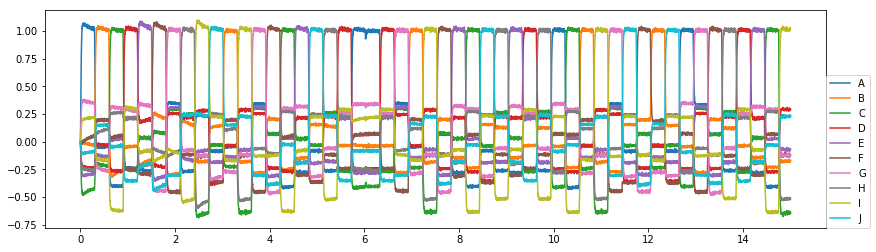

In [7]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [8]:
enc = sim.data[p_enc][-1]
dec = sim.data[p_dec][-1]

In [9]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

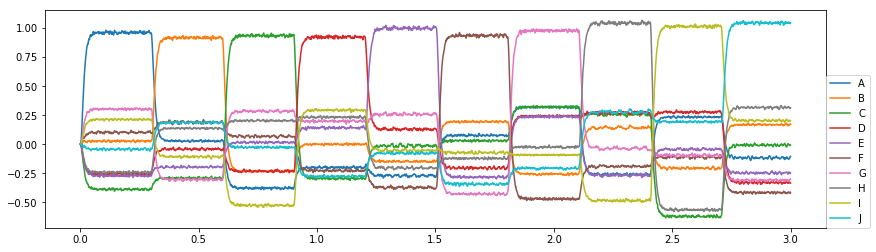

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

## Response to noisy vectors

In [11]:
base_mag = 1.

In [12]:
vecs = []

for mag in test_mags:
    vec = vocab.parse(f"{mag}*J+{base_mag-mag}*H+{base_mag-mag}*B").v
    vecs.append(vec / np.linalg.norm(vec))

In [26]:
feed = BasicVecFeed(vecs, vecs, t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model, progress_bar=None) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

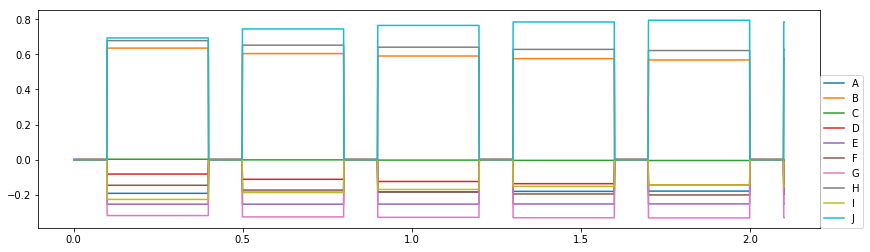

In [27]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_in], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

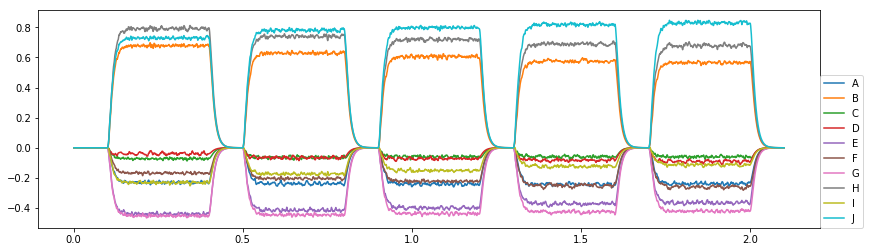

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Enhance with Semi-Analytical Rec BCM

For each pair of inputs, get the approximate change in firing rates. Scale recurrent connections accordingly.

In [16]:
t_pause = 0.1
t_each = t_present + t_pause

In [17]:
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)
td_each = int(t_each/dt)

In [18]:
t_offset = 50

In [19]:
win1 = slice(td_pause+t_offset, td_each)
win2 = slice(win1.stop+td_pause+t_offset, win1.stop+td_each)

In [41]:
def get_pair_rates(v_pair: List[np.ndarray], rec_w: np.ndarray, rec_synapse=0.005, spikes_synapse=0.01) -> List[np.ndarray]:
    feed = BasicVecFeed(v_pair, v_pair, t_present, D, len(v_pair), t_pause)

    with nengolib.Network(seed=seed) as train_model:
        in_nd = nengo.Node(feed.feed)
        output = nengo.Node(size_in=D)

        ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_w, synapse=rec_synapse)

        p_in = nengo.Probe(in_nd, synapse=None)
        p_spikes = nengo.Probe(ens.neurons, synapse=spikes_synapse)
        p_out = nengo.Probe(output, synapse=0.01)

    with nengo.Simulator(train_model, progress_bar=None) as train_sim:
        train_sim.run(len(v_pair)*t_each + t_pause)

    rates = []
    for win in (win1, win2):
        rates.append(np.mean(train_sim.data[p_spikes][win], axis=0))

    return rates

In [36]:
def calc_weights(activities: List[np.ndarray], base_inhib=-1e-5, max_excite=1e-4, plt_res=False) -> np.ndarray:
    act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

    for acts in activities:
        act_corr += np.outer(acts, acts)

    np.fill_diagonal(act_corr, 0)
    
    max_corr = np.max(act_corr)
    min_corr = np.min(act_corr)
    
    pos_corr = act_corr[act_corr > 0.]
    min_pos_corr = np.min(pos_corr)
    
    rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib
    rec_w[act_corr > 0.] = np.interp(pos_corr, (min_pos_corr, max_corr), (base_inhib, max_excite)) 
    np.fill_diagonal(rec_w, 0)
    
    if plt_res:
        fig, axes = plt.subplots(1, 2, sharex=True)
        axes[0].plot(np.sort(act_corr.flatten()))
        axes[0].set_title("Correlation")
        axes[1].plot(np.sort(rec_w.flatten()))
        axes[1].set_title("Weight Magnitude")
        
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        cax = ax.matshow(rec_w)

        fig.colorbar(cax)
    
    return rec_w

In [37]:
def test_clean_inputs(rec_w: np.ndarray, rec_synapse=0.005):
    vecs = vocab.vectors
    feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

    with nengolib.Network(seed=seed) as test_model:
        in_nd = nengo.Node(feed.feed)
        output = nengo.Node(size_in=D)
        pause = nengo.Node(lambda t: feed.paused)

        ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=rec_synapse)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_w)
        nengo.Connection(ens.neurons, output, transform=dec)

        p_in = nengo.Probe(in_nd)
        p_out = nengo.Probe(output, synapse=0.01)

    with nengo.Simulator(test_model, progress_bar=None) as test_sim:
        test_sim.run(len(vecs)*t_each + t_pause)
        
    plt.figure(figsize=(14, 4))
    plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
    plt.legend(vocab.keys(), loc=(1, 0))

In [38]:
def test_similar_inputs(rec_w: np.ndarray, rec_synapse=0.005):
    vecs = []

    for mag in test_mags:
        vec = vocab.parse(f"{mag}*J+{base_mag-mag}*H+{base_mag-mag}*B").v
        vecs.append(vec / np.linalg.norm(vec))
    
    feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

    with nengolib.Network(seed=seed) as test_model:
        in_nd = nengo.Node(feed.feed)
        output = nengo.Node(size_in=D)
        pause = nengo.Node(lambda t: feed.paused)

        ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)))
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_w, synapse=rec_synapse)
        nengo.Connection(ens.neurons, output, transform=dec)

        p_in = nengo.Probe(in_nd)
        p_out = nengo.Probe(output, synapse=0.01)

    with nengo.Simulator(test_model, progress_bar=None) as test_sim:
        test_sim.run(len(vecs)*t_each + t_pause)
        
    plt.figure(figsize=(14, 4))
    plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
    plt.legend(vocab.keys(), loc=(1, 0));

In [39]:
def test_weights(rec_w: np.ndarray, rec_synapse=0.005):
    test_clean_inputs(rec_w, rec_synapse)
    test_similar_inputs(rec_w, rec_synapse)

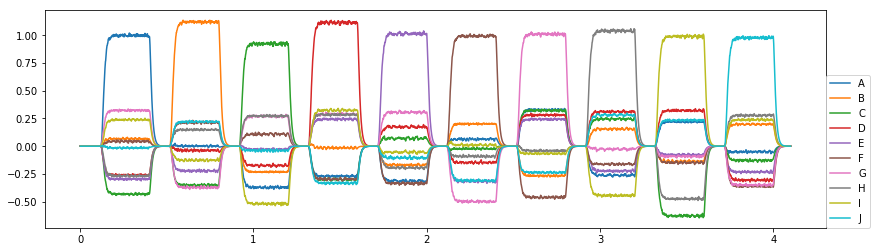

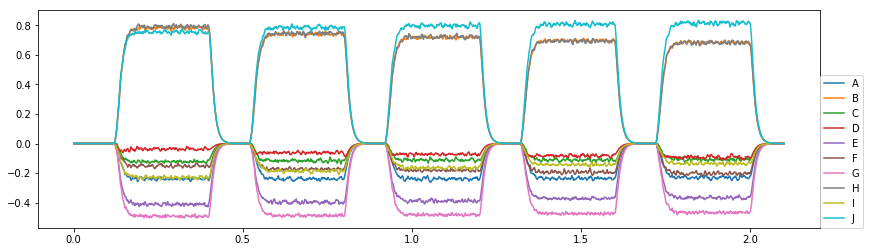

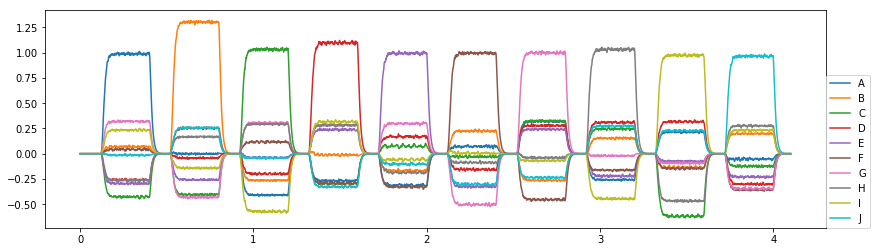

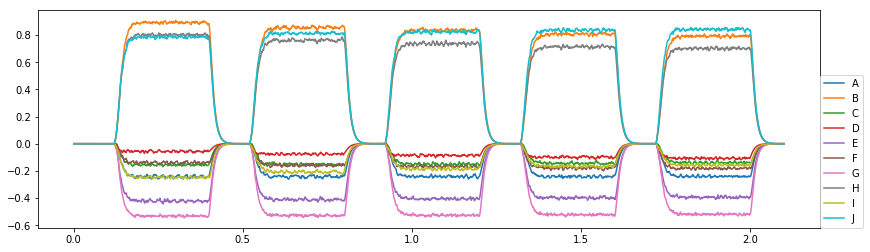

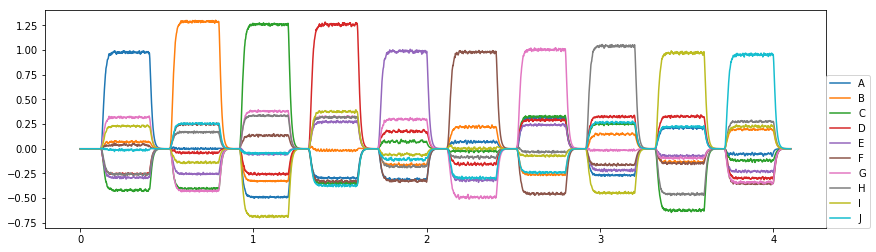

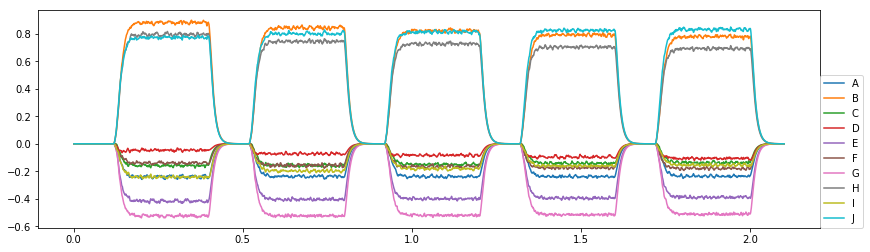

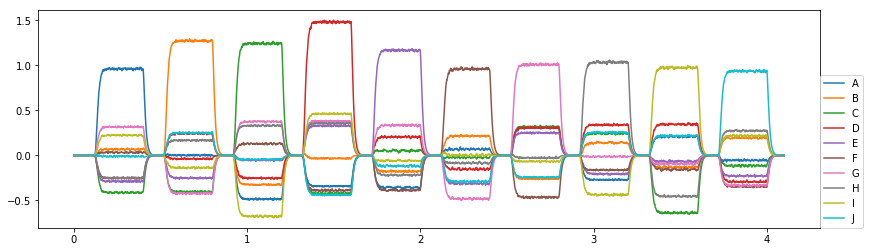

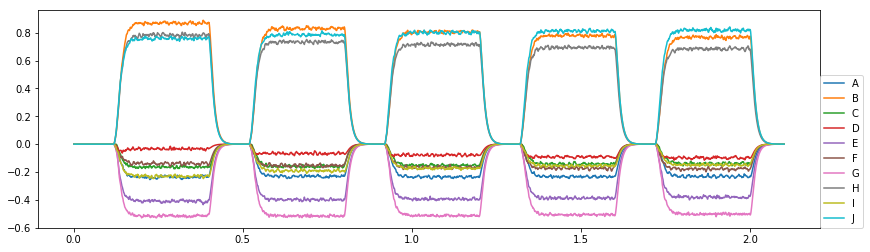

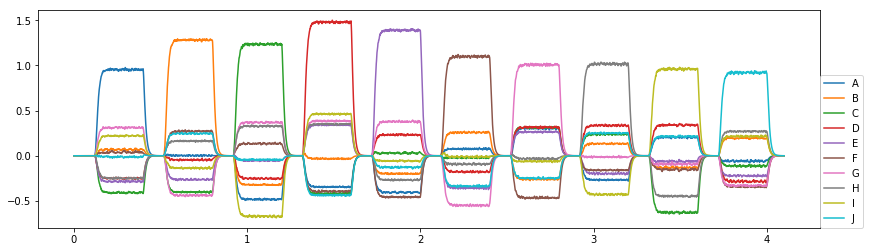

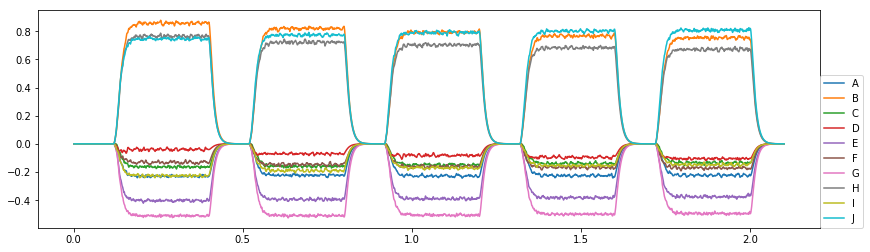

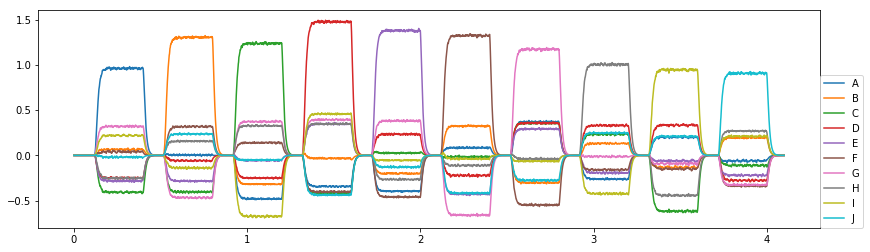

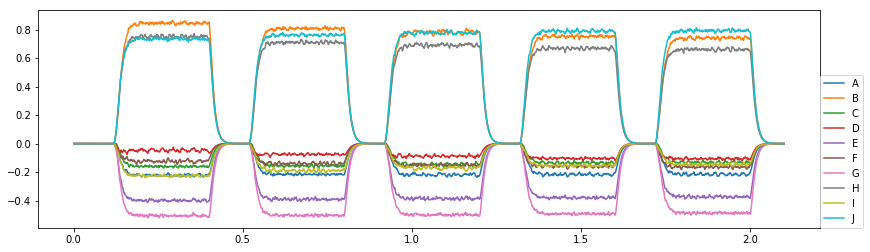

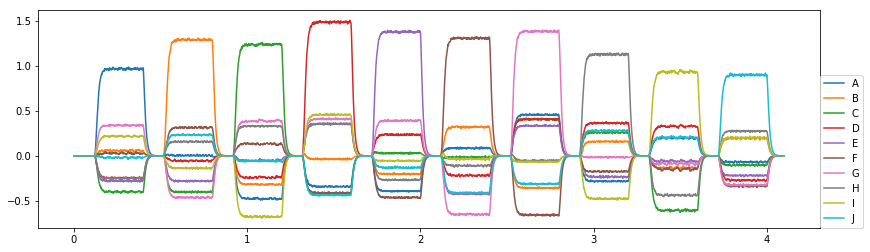

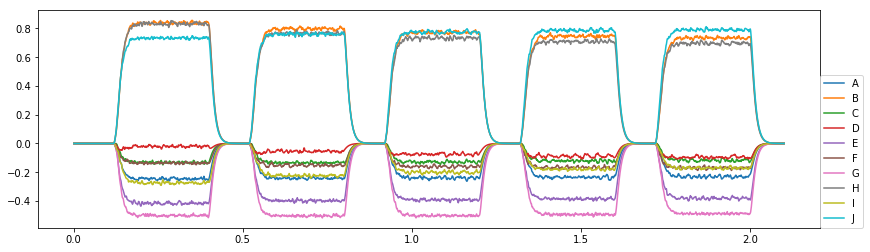

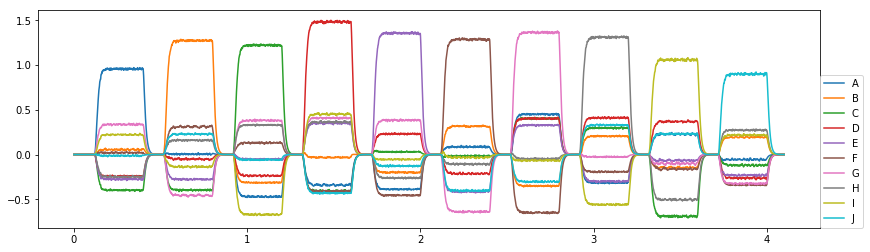

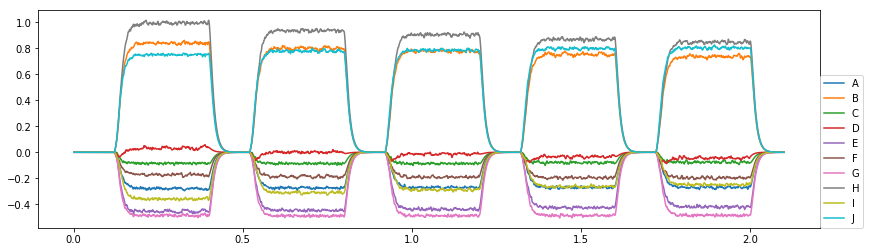

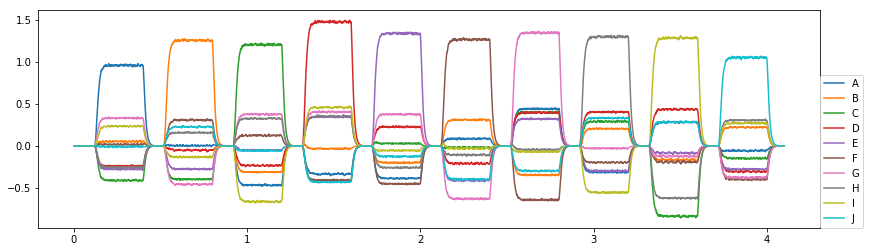

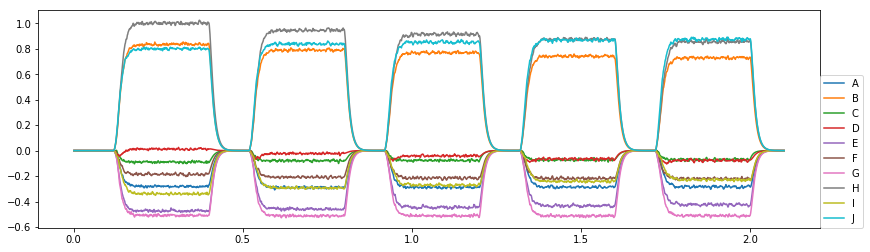

In [51]:
recur_weights = np.zeros((n_neurons, n_neurons), np.float)

for v_i in range(n_items-1):
    vec_pair = list(vocab.vectors[[v_i, v_i+1]])
    activities = get_pair_rates(vec_pair, recur_weights)
    recur_weights += calc_weights(activities, base_inhib=-1e-6, max_excite=5e-5)
    test_weights(recur_weights)

In [ ]:
cycle_vectors = 